In [40]:
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import numpy as np
import pandas_datareader.data as web
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdate
# %matplotlib notebook # interactive navigation bar 

style.use('ggplot')

In [12]:
start = dt.datetime(2000,1,1)
end = dt.datetime(2019,12,31)

df = web.DataReader('TSLA', 'yahoo', start, end)
df.to_csv('dataset/tsla.csv')
print(df.tail(1))

                  High         Low   Open       Close    Volume   Adj Close
Date                                                                       
2019-12-31  421.290009  402.079987  405.0  418.329987  10285700  418.329987


In [3]:
df = pd.read_csv('dataset/tsla.csv', parse_dates = True, index_col=0)


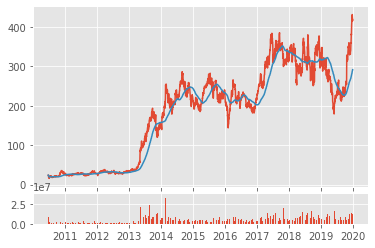

In [4]:
df['100ma'] = df['Adj Close'].rolling(100, min_periods=0).mean()

ax1 = plt.subplot2grid( (6,1),(0,0) , rowspan= 5 , colspan= 1) # shape(x,y) +  location + #rows+ #cols
ax2 = plt.subplot2grid( (6,1),(5,0) , rowspan= 1 , colspan= 1, sharex = ax1)

ax1.plot(df.index, df['Adj Close'])
ax1.plot(df.index, df['100ma'])
ax2.bar(df.index, df['Volume'])
plt.show()

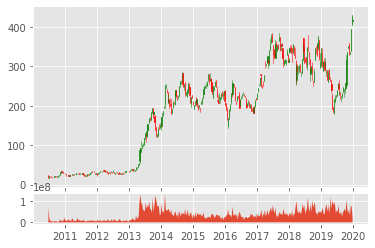

In [14]:
df_ohlc = df['Adj Close'].resample('10D').ohlc()
df_volume = df['Volume'].resample('10D').sum()
df_ohlc.reset_index(inplace=True)
df_ohlc['Date']=df_ohlc['Date'].map(mdate.date2num)


ax1 = plt.subplot2grid( (6,1),(0,0) , rowspan= 5 , colspan= 1) # shape(x,y) +  location + #rows+ #cols
ax2 = plt.subplot2grid( (6,1),(5,0) , rowspan= 1 , colspan= 1, sharex = ax1)
ax1.xaxis_date()
candlestick_ohlc(ax1, df_ohlc.values, width=2, colorup='g')
ax2.fill_between(df_volume.index.map(mdate.date2num), df_volume.values,0) # 1st curve, 2nd curve
plt.show()

In [23]:
df_ohlc = df['Adj Close'].resample('10D').ohlc()
df_volume = df['Volume'].resample('10D').sum()
df_ohlc.head(1)
df_volume[:3]
ohlc_10days = df_ohlc.join(df_volume)
ohlc_10days.columns= [i_col.capitalize()  for i_col in ohlc_10days.columns ]
ohlc_10days.head(2)

,Open,High,Low,Close,Volume
Date,,,,,
2010-06-29,23.889999,23.889999,15.800000,17.459999,70812000
2010-07-09,17.400000,20.639999,17.049999,20.639999,19489500


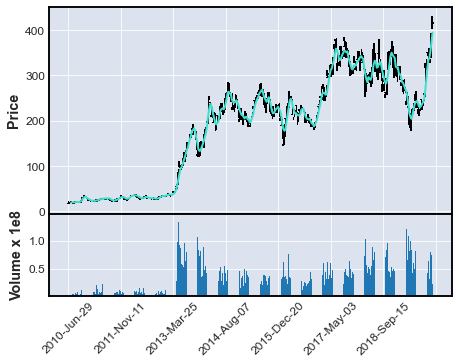

In [25]:
import mplfinance as mpf
#https://pypi.org/project/mplfinance/

mpf.plot(ohlc_10days,type='candle',mav=4,volume=True) #mav=(3,6,9)

In [3]:
import bs4 as bs
import pickle
import requests
import os

In [29]:
def save_sp500_tickers():
    resp = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class':'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:50]: # header 
        ticker = row.findAll('td')[0].text.replace('\n','')
        tickers.append(ticker)
        
    with open("sp500tickers.pickle",'wb') as f:
        pickle.dump(tickers,f)
    return tickers

In [30]:
t_list = save_sp500_tickers()
# 'BRK' in t_list

In [31]:
def get_data_from_yahoo(reload_sp500=False):
    
    # get tickers 
    if reload_sp500:
        tickers = save_sp500_tickers()
    else:
        with open("sp500tickers.pickle","rb") as f:
            tickers = pickle.load(f)
            
        
    # check if stock data exists        
    if not os.path.exists('stock_dfs'):
        os.makedirs('stock_dfs')
        
    start_dt = dt.datetime(2000,1,1)
    end_dt = dt.datetime(2019,12,31)
    
    for ticker in tickers :
        if not os.path.exists('stock_dfs/{}.csv'.format(ticker)):
            
            df = handle_exception(web.DataReader(ticker, 'yahoo', start_dt, end_dt))
            df.to_csv('stock_dfs/{}.csv'.format(ticker))
        else:
            print('Already {} exists'.format(ticker))
            
    return 

def handle_exception(function):
    try:
        return  function
    except Exception as e:
        print(e)
        pass

In [32]:
get_data_from_yahoo()

Already MMM exists
Already ABT exists
Already ABBV exists
Already ABMD exists
Already ACN exists
Already ATVI exists
Already ADBE exists
Already AMD exists
Already AAP exists
Already AES exists
Already AFL exists
Already A exists
Already APD exists
Already AKAM exists
Already ALK exists
Already ALB exists
Already ARE exists
Already ALXN exists
Already ALGN exists
Already ALLE exists
Already AGN exists
Already ADS exists
Already LNT exists
Already ALL exists
Already GOOGL exists
Already GOOG exists
Already MO exists
Already AMZN exists
Already AMCR exists
Already AEE exists
Already AAL exists
Already AEP exists
Already AXP exists
Already AIG exists
Already AMT exists
Already AWK exists
Already AMP exists
Already ABC exists
Already AME exists
Already AMGN exists
Already APH exists
Already ADI exists
Already ANSS exists
Already ANTM exists
Already AON exists
Already AOS exists
Already APA exists
Already AIV exists
Already AAPL exists


In [33]:
def compile_data():
    with open("sp500tickers.pickle","rb") as f :
        tickers = pickle.load(f)
    main_df = pd.DataFrame()
    
    for count, ticker in enumerate(tickers):
        df = pd.read_csv('stock_dfs/{}.csv'.format(ticker))
        df.set_index('Date',inplace=True)
        df.rename(columns = {'Adj Close': ticker}, inplace= True)
        df.drop(['Open','High','Low','Close','Volume'], 1, inplace=True) # axis =1  column 삭제
        
        if main_df.empty:
            main_df = df
        else:
            main_df = main_df.join(df, how='outer') # 신규상장, 상장폐지 
            
        if count%10 == 0: # verbose
            print(count)
            
        main_df.to_csv('sp500_joined_closes.csv')

In [34]:
compile_data()

0
10
20
30
40


In [35]:
m_df =pd.read_csv('sp500_joined_closes.csv')
m_df.head(2)

,Date,MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,...,AMGN,APH,ADI,ANSS,ANTM,AON,AOS,APA,AIV,AAPL
0,1999-12-31,27.323933,6.810734,NaN,18.375,NaN,1.143539,16.693562,14.46875,NaN,...,48.858738,3.643730,31.572819,2.750000,NaN,28.388517,0.652780,12.383977,14.637461,3.187337
1,2000-01-03,26.346825,6.564564,NaN,18.250,NaN,1.227554,16.274673,15.50000,NaN,...,51.197449,3.681364,30.618002,2.765625,NaN,27.678797,0.647184,11.441033,13.971079,3.470226


        MMM     ABT      ABBV      ABMD       ACN      ATVI      ADBE  \
MMM  1.0000  0.9159  0.912752  0.826385  0.945239  0.946573  0.857987   
ABT  0.9159  1.0000  0.787079  0.850569  0.982504  0.892660  0.946343   

          AMD       AAP       AES  ...      AMGN       APH       ADI  \
MMM -0.051724  0.879271 -0.179740  ...  0.945653  0.971102  0.860150   
ABT  0.077081  0.861056 -0.087399  ...  0.944028  0.974570  0.910853   

         ANSS      ANTM       AON       AOS       APA       AIV      AAPL  
MMM  0.912419  0.916854  0.936555  0.983245 -0.037788  0.837038  0.934999  
ABT  0.982810  0.959896  0.984007  0.913336 -0.080586  0.837663  0.978088  

[2 rows x 49 columns]


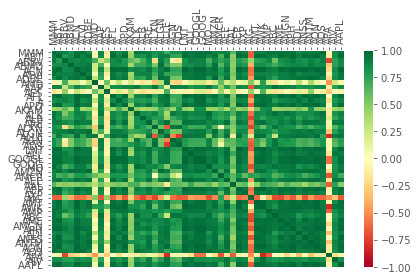

In [46]:
def visulaize_data(ticker):
    df = pd.read_csv('sp500_joined_closes.csv')

    df_corr = df.corr()
    print(df_corr.head(2))

    data = df_corr.values
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    heatmap = ax.pcolor(data, cmap = plt.cm.RdYlGn)
    fig.colorbar(heatmap)
    ax.set_xticks(np.arange(data.shape[0]) + 0.5 , minor=False)
    ax.set_yticks(np.arange(data.shape[1]) + 0.5 , minor=False)
    ax.invert_yaxis()
    ax.xaxis.tick_top() # move xaxis to top
    
    column_labels = df_corr.columns
    row_labels = df_corr.index
    
    ax.set_xticklabels(column_labels)
    ax.set_yticklabels(row_labels)
    plt.xticks(rotation=90)
    heatmap.set_clim(-1,1)
    plt.tight_layout()
    
#     df[ticker].plot()
#     plt.show()

visulaize_data('AAPL')